In [25]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lgcg'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from lgcg_stochastic import LGCG_stochastic
from lgcg import LGCG

DEBUG:matplotlib:matplotlib data path: /vol/cs-hu/hnatiuar@hu-berlin.de/miniconda3/envs/sissopp_env/lib/python3.9/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/vol/cs-hu/hnatiuar@hu-berlin.de/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/vol/cs-hu/hnatiuar@hu-berlin.de/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /vol/cs-hu/hnatiuar@hu-berlin.de/.cache/matplotlib/fontlist-v330.json


# Generate Data and Define Functions

In [2]:
Omega = np.array([[0,1],[0,1]])
alpha = 0.01
observation_resolution = 3
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])
std_factor = 1
k = lambda x: np.array([np.exp(-np.linalg.norm(point-x)**2/std_factor)/np.sqrt(std_factor*np.pi)**Omega.shape[0] for point in observations])
true_sources = np.array([[0.1,0.3], [0.25,0.8], [0.7,0.5]])
true_weights = np.array([0.2,-1.1,0.8])
u_bar = Measure(support=true_sources, coefficients=true_weights)
target = u_bar.duality_pairing(k)
norm_K_star = np.sqrt(len(observations)/(std_factor*np.pi)**Omega.shape[0])
norm_K_star_L = np.sqrt(0.5*std_factor*len(observations)/(np.pi*std_factor)**Omega.shape[0])

In [3]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(sum(c * k(x) for x, c in zip(u.support, u.coefficients)) - target) ** 2

In [4]:
def p_raw(u, k, target):
    def p_u(x):
        Ku = u.duality_pairing(k)
        inner = Ku-target
        return -np.dot(inner, k(x))
    return p_u

p = lambda u: p_raw(u, k=k, target=target)

In [5]:
def grad_k_raw(observations, std_factor):
    def grad_k(x):
        return np.array([2*(point-x)*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]) for point in observations])
    return grad_k

grad_k = grad_k_raw(observations, std_factor) # The Jacobian of k, shape=(len(observations), Omega.shape[0])

In [6]:
def hess_k_raw(observations, std_factor):
    def hess_k(x):
        first_part = lambda point: -2*np.eye(Omega.shape[0])*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        second_part = lambda point: 4*np.dot((point-x).reshape(-1,1), np.array([point-x]))*np.exp(-np.linalg.norm(point-x)**2/std_factor)/(std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0])
        return np.array([first_part(point)+second_part(point) for point in observations])
    return hess_k

hess_k = hess_k_raw(observations, std_factor) # The derivative of the Jacobian of k, shape=(len(observations), Omega.shape[0], Omega.shape[0])

In [7]:
def grad_P_raw(k, target, observations, std_factor):
    grad_k = grad_k_raw(observations, std_factor)
    def grad_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.sign(p_u(x))*np.matmul(grad_k(x).T, inner)
    return grad_P

grad_P = grad_P_raw(k, target, observations, std_factor)

In [8]:
def hess_P_raw(k, target, observations, std_factor):
    hess_k = hess_k_raw(observations, std_factor)
    def hess_P(x,u):
        p_u = p_raw(u, k, target)
        inner = target-u.duality_pairing(k)
        return np.sign(p_u(x))*np.tensordot(hess_k(x),inner,axes=([0,0]))
    return hess_P

hess_P = hess_P_raw(k, target, observations, std_factor)

In [9]:
def get_grad_j(k, grad_k, alpha, target):
    def grad_j(positions, coefs):
        to_return = []
        grad_F = (
            np.sum(
                np.array([c * k(x) for x, c in zip(positions, coefs)]),
                axis=0,
            )
            - target
        )
        for ind, x in enumerate(positions):
            # nabla_x_ind
            array = coefs[ind] * np.matmul(grad_k(x).T, grad_F)
            to_return += array.tolist()
        # nabla_u
        K = np.array([k(x) for x in positions])
        to_return += (np.dot(K, grad_F) + alpha * np.sign(coefs)).tolist()
        return np.array(to_return)
    return grad_j

grad_j = get_grad_j(k, grad_k, alpha, target)

In [10]:
def get_hess_j(k, grad_k, hess_k, target):
    def hess_j(positions, coefs):
        matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
        hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
        step = Omega.shape[0]
        coefs_delay = step*len(positions)
        inner = sum(k(x)*c for c, x in zip(coefs, positions))-target
        for i, position in enumerate(positions):
            # nabla_{x_i,x_j}
            for j, other_position in enumerate(positions):
                if j<i:
                    continue
                block = coefs[i]*coefs[j]*np.matmul(grad_k(position).T, grad_k(other_position))
                if i==j:
                    block += coefs[i]*np.tensordot(hess_k(position),inner,axes=([0,0]))
                hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
                hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
            # nabla_{x_i,u_j}
            for j, coef in enumerate(coefs):
                block = coefs[i]*np.matmul(grad_k(position).T, k(positions[j]))
                if i == j:
                    block += np.matmul(grad_k(position).T, inner)
                hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
                hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
        for i, coef in enumerate(coefs):
            # nabla_{u_i,u_j}
            for j, other_coef in enumerate(coefs):
                if j<i:
                    continue
                block = np.dot(k(positions[i]), k(positions[j]))
                hesse_matrix[coefs_delay+i,coefs_delay+j] = block
                hesse_matrix[coefs_delay+j,coefs_delay+i] = block
        return hesse_matrix
    return hess_j

hess_j = get_hess_j(k, grad_k, hess_k, target)

In [11]:
gamma = 0.5
theta = 3e-1
sigma = 1e-2
m = 1e-5
bar_m = 1e3
L = 1
R = 5e-2

In [12]:
target

array([-0.00128552,  0.04088672,  0.07873324, -0.05223227, -0.00383152,
        0.04488062, -0.1030641 , -0.05396143,  0.00068896])

In [13]:
# true_sources = np.array([[0.1,0.3], [0.25,0.8], [0.7,0.5]])
point = [0.4,0.3]
hess_P(point, u_bar)

array([[0., 0.],
       [0., 0.]])

# Test LGCG

In [14]:
exp = LGCG(target=target, 
           k=k, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           R=R
           )

In [15]:
u = exp.solve_exact(tol=1e-10)

DEBUG:root:SSN in 1 dimensions converged in 7 iterations to tolerance 1.000E-15
INFO:root:1: P_value:3.605E-02, support: [[0.05838178 0.93444806]], coefs: [-0.06084684], x: [0.90956496 0.10144454]
DEBUG:root:SSN in 2 dimensions converged in 5 iterations to tolerance 1.000E-15
INFO:root:2: P_value:1.039E-02, support: [[0.05838178 0.93444806]
 [0.90956496 0.10144454]], coefs: [-0.33428107  0.29132336], x: [1.         0.00300505]
DEBUG:root:SSN in 3 dimensions converged in 289 iterations to tolerance 1.000E-15
INFO:root:3: P_value:1.030E-02, support: [[0.05838178 0.93444806]
 [1.         0.00300505]], coefs: [-0.30756596  0.31157435], x: [0. 1.]
DEBUG:root:SSN in 3 dimensions converged in 9 iterations to tolerance 1.000E-15
INFO:root:4: P_value:4.040E-02, support: [[0.         1.        ]
 [1.         0.00300505]], coefs: [ 0.29360698 -0.32461795], x: [1. 0.]
DEBUG:root:SSN in 2 dimensions converged in 7 iterations to tolerance 1.000E-15
INFO:root:5: P_value:1.000E-02, support: [[0.      

KeyboardInterrupt: 

In [30]:
vals[0]

array([0.00021874, 0.00038027, 0.00054881, 0.00072421, 0.00090631,
       0.00109489, 0.00128975, 0.00149063, 0.00169726, 0.00190933,
       0.00212654, 0.00234853, 0.00257493, 0.00280535, 0.00303939,
       0.0032766 , 0.00351656, 0.00375878, 0.00400278, 0.00424808,
       0.00449417, 0.00474052, 0.00498661, 0.00523191, 0.00547589,
       0.00571799, 0.00595767, 0.00619441, 0.00642765, 0.00665687,
       0.00688155, 0.00710115, 0.00731519, 0.00752316, 0.0077246 ,
       0.00791903, 0.00810603, 0.00828516, 0.00845603, 0.00861826,
       0.0087715 , 0.00891543, 0.00904974, 0.00917416, 0.00928845,
       0.00939241, 0.00948584, 0.00956861, 0.00964058, 0.00970167,
       0.00975182, 0.00979101, 0.00981925, 0.00983656, 0.00984303,
       0.00983874, 0.00982382, 0.00979843, 0.00976274, 0.00971697,
       0.00966134])

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f1865d01850>


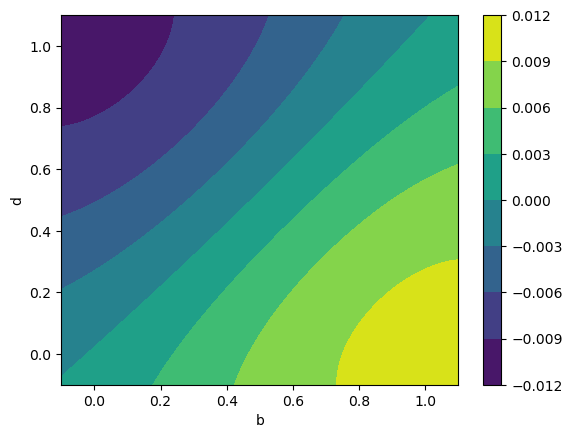

In [32]:
u_tilde = Measure(support=[[0,1],[1,0.00300505]], coefficients=[-0.32461795, 0.29360698])
P = lambda x: p(u_tilde)(x)
a = np.arange(-0.1,1.1,0.02)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((61,61))

plt.contourf(B, D, vals)
plt.colorbar()
plt.xlabel('b')
plt.ylabel('d')
plt.show()

# Test Stochastic

In [3]:
data_path = "../../sisso/src/test/thermal_conductivity_data.csv"
exp = LGCG_stochastic(data_path=data_path, alpha=0.1)

In [4]:
exp.solve(tol=1e-7)

INFO:root:---------------------
INFO:root:---------------------


Time to generate feat space: 262.406 s


INFO:root:0.9755782288434427
INFO:root:1
INFO:root:K []
INFO:root:[0.01650826 0.08398484 0.03875523 0.03877598 0.04318637 0.04194306
 0.04804311 0.06922419 0.08354961 0.11852333 0.04570393 0.04838697
 0.06082152 0.04974988 0.03391667 0.03654056 0.03532187 0.03515929
 0.04248941 0.04185097 0.0362112  0.07187031 0.0379061  0.04252391
 0.03777911 0.13475375 0.12981585 0.11154833 0.34266939 0.21564257
 0.06654163 0.12626913 0.13974483 0.09623659 0.11400463 0.09425901
 0.15303787 0.08798618 0.07927755 0.18412779 0.18997568 0.23295921
 0.08915301 0.20109564 0.13541286 0.09429843 0.07918945 0.06793185
 0.06641488 0.1338539  0.12592129 0.12139781 0.13090409 0.1034475
 0.08834254 0.1011218  0.05419033 0.06345643 0.05942181 0.05300143
 0.0721522  0.09091953 0.08603043 0.10407362 0.1014441  0.065165
 0.19817434 0.27812532 0.24831032 0.06895994 0.13319063 0.11928598
 0.08974987 0.10409334 0.06904784]
/vol/cs-hu/hnatiuar@hu-berlin.de/Dokumente/lazified-generalized-conditional-gradient/lgcg/lgcg_sto

Time to generate feat space: 262.994 s


INFO:root:0.9539958314747843
INFO:root:1
INFO:root:['((omega_Gamma_max / sigma_os) / (Theta_p * L_min_prim))']
INFO:root:2: Phi 3.106E+00, epsilon 6.361E+00, support 1, Psi 5.050E+00
INFO:root:K [[0.01650826 0.08398484 0.03875523 0.03877598 0.04318637 0.04194306
  0.04804311 0.06922419 0.08354961 0.11852333 0.04570393 0.04838697
  0.06082152 0.04974988 0.03391667 0.03654056 0.03532187 0.03515929
  0.04248941 0.04185097 0.0362112  0.07187031 0.0379061  0.04252391
  0.03777911 0.13475375 0.12981585 0.11154833 0.34266939 0.21564257
  0.06654163 0.12626913 0.13974483 0.09623659 0.11400463 0.09425901
  0.15303787 0.08798618 0.07927755 0.18412779 0.18997568 0.23295921
  0.08915301 0.20109564 0.13541286 0.09429843 0.07918945 0.06793185
  0.06641488 0.1338539  0.12592129 0.12139781 0.13090409 0.1034475
  0.08834254 0.1011218  0.05419033 0.06345643 0.05942181 0.05300143
  0.0721522  0.09091953 0.08603043 0.10407362 0.1014441  0.065165
  0.19817434 0.27812532 0.24831032 0.06895994 0.13319063 0.1